# Tuning curves and place cells

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Francesco Battaglia, Davide Spalla


**In this lesson you will learn:**
- How to visualize the response of single neurons with peri-stimulus time histograms (PSTH) and tuning curves
- How to use these techniquese to study space-selective cells (Place Cells) in the hippocampus
- How to quantify the selectivity of single cells



In [19]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
from code.utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


In [20]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

## Introduction: visualizing the response of a neuron
---

In order to understand how neurons encode information about the external world, neuroscientists are in the habit to look for chenges in the activity of individual cells as a funtion of, for example, the presence/absence of a stimulus, the time elapsed from a certain event, or the value of a particular behavioural feature, such as the position of the animal in an environment, the orientation of a presented visual image or the running speed.

A fist important step in the caracterization of this selectivity is the visual ispection of neural responses. In this lesson we will look at three useful methods to visualize the activity of single neurons, and apply them to a couple of paradigmatic neural data analysis cases: the response of neurons in the auditory cortex during a sound presentation, and the analysis of hippocampal place cells.

**Raster plots**  

Raster plots are useful to visualize the spiking activity of neurons in a given time windows.
They visualize each spike as a dot or a small line, with a position along the x axis that corresponds to the emission time.  
The y axis usually displays different neurons,to give a glimpse of the overall population activity in the given time window, or different trials, to show how variable the response of the visualized neuron is from one trial to the other.
To build a raster plot we:
- isolate the spikes emitted during the periods of interests
- align the spikes to the onset (or some other time of interest) of the period of interest
- Plot each spike as a dot with x corresponding to its aligned emission time, and y corresponding to the neuron it was emitted by (or the repetition during which it was emitted).



**Peri-stimulus time histogram (PSTH)**

Peri-stimulus time histograms are used to visualize the timecourse of the activation of a neuron in response to a certain event, repeated a number $r$ of times.
To build the PSTH we:
- Build the rasterplot of the neuron
- Bin the interval in $N$ intervals of size $\Delta$
- Count the total number of spikes $n_{i}$ that fall into bin $i$
- Plot the count $n_{i}$ for each bin, or the firing rate $n_{i}/ r \Delta$

This yields an histogram of the number of spikes (or the firing rate) for each time bin of the period of interest.


**Tuning curves**

To investigate the modulation of the activity of a neuron as a fucntion of a continuous parameter $S$ (usually an external stimulus, or a behavioural correlate), we can look at the neuron's *tuning curve*.  
The tuning curve $ <r> = f(s)$ gives the expected firing rate of the neuron given that $S$ assumes the value $s$.
To build a tuning curve we:
- Bin the parameter $S$ in $N$ bins of size $\Delta s$
- Compute, for each bin, the average firing rate of the neuron during the periods in which S assumes values within the bin.
- Optionally, fit a functional form to the obtained histogram

This procedure yields an histogram, that gives us information about how the neuron responds to different values of the $S



## Raster plot and PSTH example: sound presentation 
---
To see how to build a PSTH in practice, let's look at some simulated data.   
The data contains the recordings from 20 neurons in the auditory cortex, collected during the repeated presentation of two different sounds. Each sound is presented 50 times, each time for a duration of 2 seconds, with a pause of 3 seconds between each presentation. The two different sounds are randomly interlieved during the course of the experiment.

The `phts_data.pickle` contains the data in a python dictionary, with the follwing keys:
- `spike_times` contains a list of lists, with the timestamps of the emitted spikes of each neurons, in seconds
- `stim_onsets` contains a list of the onset times of each of the presented sounds, in seconds
- `stim_type` contains a list of the sound identity corresponding to the onsets in `stim_onsets`
- `stim_duration` contains a single number, giving the duration of the sounds in seconds

Let's import and unpack the data

In [3]:
#import data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']


We now extract the periods around the stimulus presentations (from 0.5s before the onset to 0.5s after the offset), and align the spike times to the stimulus onset. We do that separately for each of the two stimului.

In [4]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5


aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim1_onsets = stim_onsets[stim_type==2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim2.append(aligned_spikes)
        

Let's plot the response to each neuron to each sound using a *raster plot*, in which each spike, for each presentation is visualized with the respective emission time (with respect to the onset of the sound) and the PSTH, in which all presentation are collapsed together, and the number of spikes emitted in a given time window is visualized as an histogram.

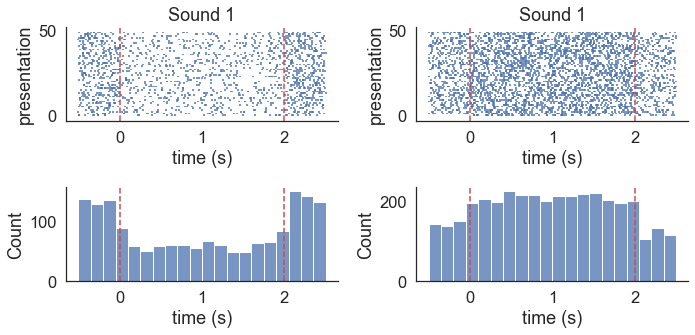

In [5]:
neuron = 6 # neuron to plot
 

psth_spikes_stim1 = [item for sublist in aligned_spikes_stim1[neuron] for item in sublist]
psth_spikes_stim2 = [item for sublist in aligned_spikes_stim2[neuron] for item in sublist]

plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
plt.title('Sound 1')
plt.eventplot(aligned_spikes_stim1[neuron]);
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,2)
plt.title('Sound 1')
plt.eventplot(aligned_spikes_stim2[neuron]);
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,3)
sns.histplot(psth_spikes_stim1,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.subplot(2,2,4)
sns.histplot(psth_spikes_stim2,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.tight_layout()

As you can see some neurons (e.g. neuron 6), clearly show a modulation of the firing rate depending on the stimulus presentation and the stimulus identity. In this case the modulation is sustained throughout the presentation. 

Rasterplots and PSTH are usefull tools to visually inspect the response of single neurons, to get some insight on the neural responses and theri temporal profile.

## Tuning curve example: Place cells
---

Place cells are cells in the hippocampus that activate when the animal (typically rat or mouse) passes through a specific place in an environment. Together place cells for a spatial map of the environment that is supposed to support episodic memory. A good review on place cells is the one by [Moser et al](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.31.061307.090723?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed). Some more information on the hippocampus [here](http://www.scholarpedia.org/article/Hippocampus#Hippocampal_place_cells_and_episode_cells)

In a typical place cell experiment, multiple hippocampal neurons are recorded at the same time eg. with a multi-tetrode array. For each cell (as a result of the spike sorting process, that we will not cover here) we get the time series of the times of the spikes that each cell emitted. In addition we will get information about the position of the animal at any point in time. Typically, this is obtained by filming the animal movement with a video-camera, and use a video-tracking algorithm to find the animal position in each frame. Thus, we will get a time series with the times of each frame and the position of the animal (X and Y coordinates, or in the case of running on a linear track, only a 1-D coordinate. To find the animal position at the moment of the emission of each spike (which is the basic unit of information for our analysis) we will therefore have to "synchronize and realign" these different types of time series. 

### Simulating place cell activity

To get started, we will create and analyze some simulated data, where we will have more control. We will first generate "ground truth" firing rate maps, and then simulate spike trains as inhomogeneous Poisson processes, with a rate determined by the current animal position. 
An inhomogeneous Poisson process is a random process where the instantaneous probability to have an event at time $t$ (more precisely, the probability of having an event between times $t$ and $t + dt$ is given by:

$$p(event in [t, t+dt]) = \lambda(t)dt$$

Here we define the parameters for the simulation. We will consider a 1-D environment, such as linear track

In [6]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

The probaility distribution for the place field size has shape

Text(0, 0.5, 'Probability')

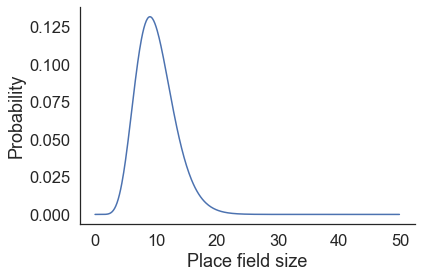

In [7]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

In [8]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Text(0, 0.5, 'cell #')

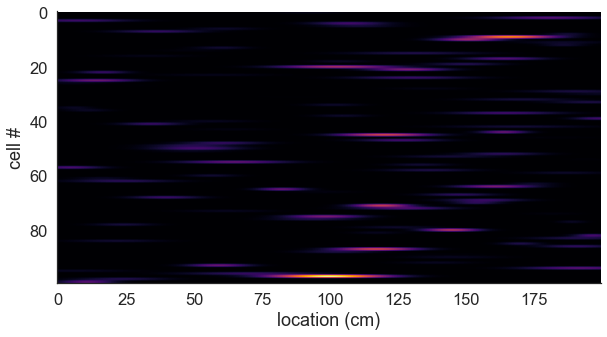

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

Now plotting them in the order of place field (common plot type in the field)

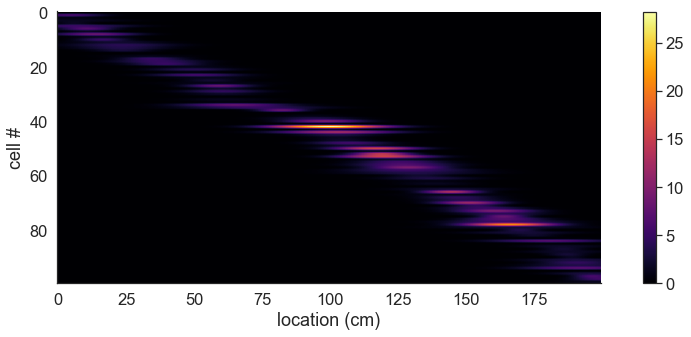

In [10]:
plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Now let's simulate the "mouse" trajectory. The mouse will shuttle back and forth on the linear track and will stop at the two ends to eat. We will make a very rough simulation, in which the running speed will be constant for each run

In [11]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

t` and `x` are, respectively, the times, and position readouts for all the video frames. This pair represent the first time series that we will encounter in a typical experiment. 

This is what the mouse trajectory looks like

Text(0, 0.5, 'position on track (cm)')

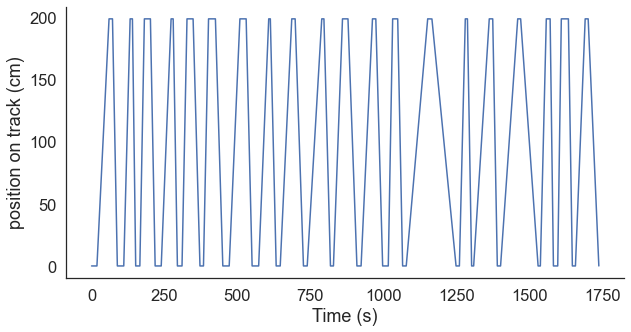

In [12]:
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

The cell below draws spikes according to an inhomogeneous Poisson process. This is the heart of the simulation. Look at the `for` loop, what is each line of code doing?

In [13]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


<div class="alert alert-block alert-success"> 

### Displaying loop progress with TQDM

`tqdm` is a useful tool for visualizing progress during long code executions. In its simplest instance it just wraps any [iterable](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Iterables.html) and shows a progress bar with the percentage of completion, the fraction of iterations performed, the total time and the average number of iterations per second. To use it on an iterator `iter`, just do:
```
for i in tqdm(iter):
   #code
```
For more info check out the [tqdm github page](https://github.com/tqdm/tqdm)

## Analysis of place-related spiking activity

`spikes` and the pair `t, x` contain the information that we typically get from an experiment, and our analysis will focus on those. 

In the lines below, we plot the positions at which the spikes are emitted. 

Note:

- We use `np.interp` (check the documentation!) to realign the spikes and the position time series. That instruction returns an array of positions at which spikes were fired. This time-to-space mapping is an important operation that will come up many times in this kind of analysis.

- We use `interact` (from `ipywidgets`) to make an interactive plot so that we quickly explore the behavior of all cells


In [14]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [15]:
spike_positions = [np.interp(s, t, x) for s in spikes]

<div class="alert alert-block alert-success"> 

### List comprehension

 In the cell above we used a _list comprehension_, a typical python construct (check the docs if you don't know what that is! Spoiler: it's a handy way to replace a for loop)

Now let's make experimental firing rate maps, by taking the histogram of the spikes at each position and normalizing it by the "occupancy" that is, the time at each point on the track.

In [16]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

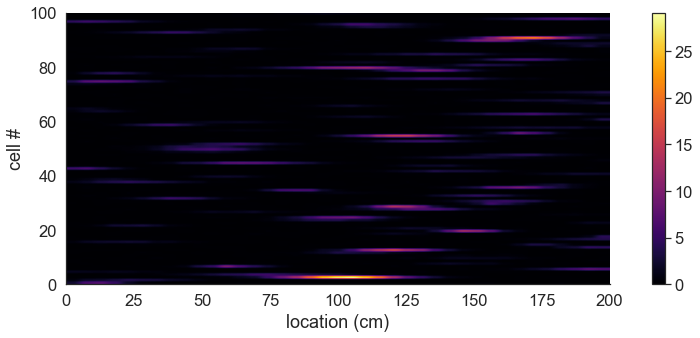

In [17]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

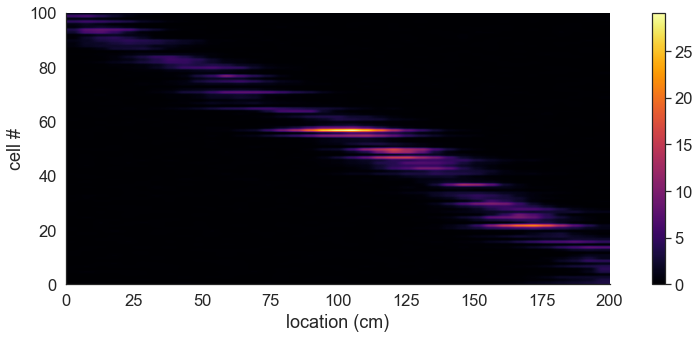

In [18]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Tuning curve can help us explore the selectivity of individual neurons to a particular stimulus. In the example we have seen, we can reconstruct the selectivity of place cells with good accuracy. In particular, we obtain an estimate of the preferred firing location of the cell (from the maximum of the tuning curve, or it's center of mass), of the place field size (from the width of the tuning curve).

## Spatial information 

What makes a place cell? We are looking for cells with some amount of spatial selectivity. But how to we define/quantify that precisely?
One way is to use information theory. In particular [mutual information]() is a way to quantify the degree of association between two random variables, such as the firing of an hippocampal cell and the position of a mouse. [Skaggs et al.](https://papers.nips.cc/paper/671-an-information-theoretic-approach-to-deciphering-the-hippocampal-code.pdf) defined a widely used formula to compute a related quantity, usually called "spatial information"  for the case of place cells. 

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

You will have the chance to try and implement a function to compute the spatial information in the exercises for this lesson.

<div class="alert alert-block alert-info">


### Key points 

- PSTH and tuning curves are useful tools to visualize stimulus-related nerual activity.  
- Place cells are cell whose firing rate is modulated by the animal's position in an environment.  
- The selectivity of place cells can be visualized with their firing rate maps (space related tuning curves), and quantified with information metrics such as the Mutual Information

<div class="alert alert-block alert-info">


### References and resources

**Books & papers**
* For an introduction to tuning curves and neural coding, see Chapter 1 of [Theoretical Neuroscience](http://www.gatsby.ucl.ac.uk/~lmate/biblio/dayanabbott.pdf)
* [Place cells,grid cells and memory](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315928/) gives a nice overview of the significance of place cells (and their cousins, grid cells)

**Software**
* [Pynapple](https://github.com/PeyracheLab/pynapple) is a python library with lots of tools for visualization of single cell selectivity (and more)



## Exercises
You can find the exercises for this lessons in [exercises.ipynb](exercises.ipynb)